In [341]:
import os
import csv
import audata as aud
import shutil
import numpy as np
import pickle
import random
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
import ruptures as rpt
from IPython.display import display, HTML

import sklearn
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mutual_info_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.metrics import roc_auc_score, classification_report

In [236]:
file_path = "/zfsauton2/home/vsanil/pmx_cpu/"
dict_name = "rrd_dict_lov_low.p"
cwd = os.getcwd()

In [3]:
# Load the features
rrd_dict = {}
with open(os.path.join(file_path, dict_name), 'rb') as f:
    rrd_dict = pickle.load(f)

In [4]:
# Get th elist with highest length
def get_highlen(inp_dict):
    # Find the longest length in dict
    high_len = 0
    for values in inp_dict.values(): 
        if len(values) > high_len:
            high_len = len(values)
    return high_len

# Add time column to the dictionary
def add_time_col(inp_dict, step=0.5):
    high_len = get_highlen(inp_dict)
    t_vals, count = [], 0
    for _ in range(high_len):
        t_vals.append(count)
        count += step 
        
    inp_dict['time'] = t_vals
    
    return inp_dict

# Generate a CSV from input
def generate_csv(inp_dict, path, split=False, dir_name=None):
    if not split:    
        name_list = []
        if 'time' in inp_dict:
            name_list = ['time']
            val = list(inp_dict.keys()) 
            val.remove('time')
            name_list.extend(val)
        else:
            name_list.extend(list(inp_dict.keys()))

        # Split dictionary to list of dictionaries
        list_dict = []
        for i in range(get_highlen(inp_dict)):
            val = {}
            for key, values in inp_dict.items():
                try:
                    val[key] = values[i]
                except IndexError as error:
                    continue
            list_dict.append(val)

        try:
            with open(path, 'w') as f:
                writer = csv.DictWriter(f, fieldnames=name_list)
                writer.writeheader()
                for data in list_dict:
                    writer.writerow(data)
        except IOError:
            print("I/O Error")
    else:
        for key, value in inp_dict.items():
            if key != 'time':
                value = [x for x in value if not isinstance(x, str)]
                val_len = len(value)
                value.insert(0, key)
                t_col = inp_dict['time'][:val_len]
                t_col.insert(0,'time')
                rows = zip(t_col, value)
                with open(os.path.join(path, dir_name+"_"+''.join(key.split('.')[:-1])+'_input.csv'), 'w') as f:
                    writer = csv.writer(f)
                    for row in rows:
                        writer.writerow(row)

In [5]:
lov3_dict = add_time_col(rrd_dict['lov3']['value-dict'], step=1)
low1_dict = add_time_col(rrd_dict['low1']['value-dict'], step=1)

In [6]:
# Generate input CSVs for honey
#inp_dir_csv = os.path.join(file_path, "csvs")
inp_dir_csv = os.path.join(file_path, "split_csvs")
if not os.path.exists(inp_dir_csv):
    os.mkdir(inp_dir_csv)

#generate_csv(lov3_dict, os.path.join(inp_dir_csv, "lov3_input.csv"))
generate_csv(lov3_dict, inp_dir_csv, True, "lov3")
generate_csv(low1_dict, inp_dir_csv, True, "low1")

In [7]:
inputFold = 'op_bins'
fList = os.listdir(inputFold)

with open('test.sevt', 'a') as f:

    f.write('offset 3600\n\n')

    for k, fn in enumerate(fList):

        f.write('sequence {}\n'.format(k))
        f.write('dataset {}/{}\n'.format(inputFold, fn))
        if "lov3" in fn:
            f.write('event begin class 0\n')
        if "low1" in fn:
            f.write('event begin class 1\n')
        f.write('flush\n\n')

In [255]:
def gen_roc_curve(fpr, tpr, roc_auc,classifier_type):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', \
        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example for {}'.format(classifier_type))
    plt.legend(loc="lower right")
    plt.show()
    
def gen_prec_recall_curve(recall, precision, classifier_type):
    plt.figure()
    lw = 2
    plt.plot(recall, precision, color='darkorange', \
        lw=lw)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall curve for {}'.format(classifier_type))
    #plt.legend(loc="lower right")
    plt.show()  
    
def au_plots(preds, true_labels):
    print(preds.shape)
    fold_path = os.path.join(os.getcwd(), "pred_csvs")
    csv_path = os.path.join(fold_path, "predictions.csv")
    
    if not os.path.exists(fold_path):
        os.mkdir(fold_path)
        
    true_labels = np.where(true_labels == 0, "fail", "no_fail")
    predictions = pd.DataFrame({'no_fail':preds[:,0], 'fail':preds[:,1], 
                            'true_output':true_labels})
    display(predictions.head())
    display(predictions['true_output'].value_counts())
    predictions.to_csv(csv_path, sep=',', index=False)
    
    # Generate ROCs
    os.system('./random_forest option roc ds pred_csvs/predictions.csv')
    for f in os.listdir(os.getcwd()):
        if f.endswith('_roc.csv'):
            path_name = os.path.join(os.getcwd(), 'pred_csvs')
            shutil.move(f, path_name)
            cmd = 'python 2class_process_roc_stds.py {}'.format(os.path.join(path_name, f).replace('.csv',''))
            os.system(cmd)
    
    print(os.listdir(fold_path))
    # Get ROCs
    a1 = pd.read_csv('pred_csvs/A1_roc_std.csv')
    a2 = pd.read_csv('pred_csvs/A2_roc_std.csv')
    
    ## three roc curves in one plot

    ## ROC curves of a random classifier, for reference
    RANDOM_FP = np.arange(0, 1., 0.01)
    RANDOM_TP = np.arange(0, 1., 0.01)
    RANDOM_FP[0] = 1e-4
    RANDOM_TP[0] = 1e-4

    ## Mean and confidence bands of FPR V.S. TPR curve
    conf_UB = a1[['FP1UB', 'TP1UB']].copy()
    conf_UB.columns = ['X', 'Y']
    conf_LB = a1[['FP1LB', 'TP1LB']].iloc[range(a1.shape[0]-1, -1, -1)]
    conf_LB.columns = ['X', 'Y']
    conf = pd.concat((conf_UB, conf_LB))

    fig = plt.figure(figsize=(15, 4))

    ## FPR V.S. TPR curve
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(a1['FP1'], a1['TP1'], color='C1')
    poly = Polygon(list(zip(conf['X'], conf['Y'])))
    poly = PolygonPatch(poly, linewidth=0, fc='C1', alpha=0.4)
    ax.add_patch(poly)
    plt.plot(RANDOM_FP, RANDOM_TP, color='black', linestyle='--')
    plt.xlabel('FPR', fontsize=14)
    plt.xlim(-0.05, 1.05)
    plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.ylabel('TPR', fontsize=14)
    plt.ylim(-0.05, 1.05)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.grid(linestyle='--')

    ## FPR (log-scale) V.S. TPR curve
    ax = fig.add_subplot(1, 3, 2)  
    plt.plot(a1['FP1'], a1['TP1'], color='C1') 
    poly = Polygon(list(zip(conf['X'], conf['Y'])))
    poly = PolygonPatch(poly, linewidth=0, fc='C1', alpha=0.4)
    ax.add_patch(poly)
    plt.plot(RANDOM_FP, RANDOM_TP, color='black', linestyle='--')
    plt.xlabel('FPR', fontsize=14)
    plt.xscale('log',basex=10) 
    plt.xlim(0.6*1e-4, 1.6)
    plt.xticks([1e-4, 1e-3, 1e-2, 1e-1, 1.0], ['$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '1.0'])
    plt.ylabel('TPR', fontsize=14)
    plt.ylim(-0.05, 1.05)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.grid(linestyle='--')
    plt.title('ROC curves', fontsize=15, pad=10)

    ## here A2 treats the 2nd class 'usa' as positive and the 1st class 'asia' as negative 
    conf_UB = a2[['FP1UB', 'TP1UB']].copy()
    conf_UB.columns = ['X', 'Y']
    conf_LB = a2[['FP1LB', 'TP1LB']].iloc[range(a2.shape[0]-1, -1, -1)]
    conf_LB.columns = ['X', 'Y']
    conf = pd.concat((conf_UB, conf_LB))

    ax = fig.add_subplot(1, 3, 3) 
    plt.plot(a2['FP1'], a2['TP1'], color='C0') 
    poly = Polygon(list(zip(conf['X'], conf['Y'])))
    poly = PolygonPatch(poly, linewidth=0, fc='C0', alpha=0.4)
    ax.add_patch(poly)
    plt.plot(RANDOM_FP, RANDOM_TP, color='black', linestyle='--')
    plt.xlabel('FNR', fontsize=14)
    plt.xscale('log',basex=10) 
    plt.xlim(0.6*1e-4, 1.6)
    plt.xticks([1e-4, 1e-3, 1e-2, 1e-1, 1.0], ['$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '1.0'])
    plt.ylabel('TNR', fontsize=14)
    plt.ylim(-0.05, 1.05)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.grid(linestyle='--')

    plt.subplots_adjust(wspace=0.4)
    plt.show()
    
    shutil.rmtree(fold_path)

In [2]:
h5_path = os.path.join(os.getcwd(), "rrd_samples", "h5s")

for fname in os.listdir(h5_path):
    lens = set()
    df = None
    file_path = os.path.join(h5_path, fname)
    if "snmp" in file_path:
        if "low1" in file_path and "autonlab" not in file_path:
            f = aud.File.open(file_path)
            hr = f['/data/']
            #print(hr.list())
            for h in hr.list()['datasets']:
                ds = f['/data/{}'.format(h)][()]
                #display(ds)
                lens.add(ds.shape[0])
                if ds.shape[0] == 2877:
                    print(h)
            print(fname, lens)
            
        if "lov11" in file_path or "lov22" in file_path:
            f = aud.File.open(file_path)
            hr = f['/data/']
            #print(hr.list())
            for h in hr.list()['datasets']:
                ds = f['/data/{}'.format(h)][()]
                #display(ds)
                lens.add(ds.shape[0])
            print(fname, lens)
        

snmp_low1.h5 {528, 529, 530, 2972, 2975}


In [322]:
def get_df(file_path, f_name, filehandler=None, power_surge=False, user_class=False):
    """
        Given a h5 file path, convert it to 
        CSV file recordings
    """
    positive_flag = True
    thresh, day = 1, 24*2
    # Number of hours to forecast
    num_hours_forecast = 0
    time_thresh = 2 * num_hours_forecast
    day_2, day_4, day_7 = day*2, day*4, day*7
    indices, days, dfs = [], [day, day_2, day_4, day_7], [{}, {}, {}, {}]
    dir_names, neg_indices, neg_dfs = ["1_day", "2_day", "4_day", "7_day"], indices, dfs
    save_path = os.path.join(os.getcwd(), "split_csvs")
    
    f = aud.File.open(file_path)
    uptime = f['/data/uptime.rrd'][()]
    if uptime.shape[0] != 147:

        # Extract 1 week, 4 day, 2 day and 1 day data
        #display(uptime)
        d = pd.DataFrame(data={'time':uptime['time'][:-1], 'values':uptime['values'][1:].values - uptime['values'][:-1].values})
        #display(uptime)
        d['values'] = d['values'].abs() > thresh * (d['values'].max())
        truth_df = d.loc[d['values'] == True]
        truth_ls = truth_df.index.tolist()
        dates = truth_df['time'].tolist()
        #print(truth_ls, dates)
        if len(truth_ls) == 0:
            positive_flag = False
        #return 
    
        # Format of indices: 1 Day, 2 Day, 4 Day, 7 Day
        if positive_flag:
            prev = 0
            flag = False
            for idx, t in enumerate(truth_ls):
                for d in days:
                    if not power_surge:
                        if t - d - time_thresh >= 0 and prev != t-1:
                            indices.append([x for x in range(t-d-time_thresh, t-time_thresh)])
                            prev = t
                            flag = True
                    else:
                        if t - d - time_thresh >= 0 and prev != t-1 and str(dates[idx])=='2020-07-09 18:06:06+00:00':
                            indices.append([x for x in range(t-d-time_thresh, t-time_thresh)])
                            prev = t
                            flag = True
                if filehandler and flag:
                    if "snmp_low1.h5" in fname or "snmp_lov3.h5" in fname:
                        dates[idx] -= timedelta(days=27)
                    print(f_name, str(dates[idx]), file=filehandler)
                    flag = False
        
        if positive_flag:
            prev = truth_ls[0]
        else:
            prev = (2877//2)
        for idx, t in enumerate(truth_ls[1:]):
            if (t - day_7) - prev > day_7:
                ind = [x for x in range(t-2*day_7, t-day_7)]
                for d in days:
                    neg_indices.append([x for x in range(t-day_7-d, t-day_7)])
                break
            else:
                prev = t
        
        hr = f['/data/']
        if positive_flag:
            # Generate the positive samples
            for h in hr.list()['datasets']:
                ds = f['/data/{}'.format(h)][()]
                for i, idx in enumerate(indices):
                    try:
                        temp_df = ds.iloc[idx]
                        if 'time' not in dfs[i]:
                            dfs[i]['time'] = temp_df['time'].values
                        dfs[i][h] = temp_df['values'].values
                    except IndexError as e:
                        break
                    
        # Generate the negative samples
        for h in hr.list()['datasets']:
            ds = f['/data/{}'.format(h)][()]
            for i, idx in enumerate(neg_indices):
                try:
                    temp_df = ds.iloc[idx]
                    if 'time' not in neg_dfs[i]:
                        neg_dfs[i]['time'] = temp_df['time'].values
                    neg_dfs[i][h] = temp_df['values'].values
                except IndexError as e:
                    break
        
        # Create CSVs
        for i, d in enumerate(dir_names):
            if positive_flag:
                dfs[i], neg_dfs[i] = pd.DataFrame(data=dfs[i]), pd.DataFrame(data=neg_dfs[i])
                dfs[i]['time'] = [x for x in range(0, dfs[i].shape[0])]
                neg_dfs[i]['time'] = [x for x in range(0, neg_dfs[i].shape[0])]
                dfs[i].to_csv(os.path.join(save_path, d, f_name+"_positive.csv"), index=False)
                neg_dfs[i].to_csv(os.path.join(save_path, d, f_name+"_negative.csv"), index=False)
            else:
                neg_dfs[i] = pd.DataFrame(data=neg_dfs[i])
                neg_dfs[i]['time'] = [x for x in range(0, neg_dfs[i].shape[0])]
                neg_dfs[i].to_csv(os.path.join(save_path, d, f_name+"_negative.csv"), index=False)
        #display(dfs[i])

with open("dates.txt", "w") as f:
    f.write("Date Time logs for all failure\n\n")

#if clear=="True":
#    val = os.system("./")
ignore_names = ["bhyve", "ourea", "warden", "uranus"]
with open("dates.txt", "a") as f:
    for fname in os.listdir(h5_path):
        file_path = os.path.join(h5_path, fname)
        check_set = set()
        if "snmp" in file_path:
            if "low1" in file_path and "autonlab" in file_path:
                continue
            if "lov3" in file_path and "autonlab" in file_path:
                continue
            if any(n in file_path for n in ignore_names):
                continue
            print(fname)    
            get_df(file_path, fname, f)
            print("\n\n\n", file=f)

snmp_lnet3.int.autonlab.org.h5
snmp_gpu23.int.autonlab.org.h5
snmp_lnet4.int.autonlab.org.h5
snmp_titan.int.autonlab.org.h5
snmp_lop1.int.autonlab.org.h5
snmp_apcf10e82.int.autonlab.org.h5
snmp_areas.int.autonlab.org.h5
snmp_horae.dmz.autonlab.org.h5
snmp_gpu18.int.autonlab.org.h5
snmp_lov1.int.autonlab.org.h5
snmp_gpu9.int.autonlab.org.h5
snmp_lov6.int.autonlab.org.h5
snmp_lock.dmz.autonlab.org.h5
snmp_gpu16.int.autonlab.org.h5
snmp_lov8.int.autonlab.org.h5
snmp_gpu11.int.autonlab.org.h5
snmp_gpu7.int.autonlab.org.h5
snmp_apollo.int.autonlab.org.h5
snmp_neill-zfs.int.autonlab.org.h5
snmp_gpu20.int.autonlab.org.h5
snmp_atlas.int.autonlab.org.h5
snmp_gpu12.int.autonlab.org.h5
snmp_gpu4.int.autonlab.org.h5
snmp_gpu15.int.autonlab.org.h5
snmp_gpu3.int.autonlab.org.h5
snmp_lov5.int.autonlab.org.h5
snmp_pdu-c.int.autonlab.org.h5
snmp_lov2.int.autonlab.org.h5
snmp_lov9.int.autonlab.org.h5
snmp_gpu10.int.autonlab.org.h5
snmp_apcdc147c.int.autonlab.org.h5
snmp_gpu6.int.autonlab.org.h5
snmp_gpu

In [323]:
# Directory list of where-whats
# Output of get_df: /zfsauton2/home/vsanil/pmx_cpu/split_csvs --> day wise data contained within
# Select a day
# Call the split csv function to split the csvs for that day
# This data will be stored in /zfsauton2/home/vsanil/pmx_cpu/honey_features/split_csvs
# Call create_hny.py to create honey features to store into /zfsauton2/home/vsanil/pmx_cpu/honey_features/csv_features
# Classify upon this
day_num = 1

In [324]:
def split_csv(file_path, out_path):
    col_names = ['processor-hr', 'sensor-temperature']
    file_path = os.path.join(file_path, "{}_day".format(day_num))
    for f in os.listdir(file_path):
        print(f)
        filename = os.path.join(file_path, f)
        df = pd.read_csv(filename, sep=',')
        #display(df)
        for c_names in list(df.columns):
            if any(c in c_names for c in col_names):
                df_dict = {'time':df['time'], c_names:df[c_names]}
                save_df = pd.DataFrame(data=df_dict)
                save_path = os.path.join(out_path, f.replace('.csv','')+"_"+c_names.replace('.rrd','')+'.csv')
                save_df.to_csv(save_path, sep=',')

In [325]:
inp_path = os.path.join(os.getcwd(), "split_csvs")
out_path = os.path.join(os.getcwd(), "honey_features", "split_csvs")
split_csv(inp_path, out_path)

snmp_gpu8.int.autonlab.org.h5_positive.csv
snmp_apc9d5b55.int.autonlab.org.h5_positive.csv
snmp_gpu4.int.autonlab.org.h5_negative.csv
snmp_gpu1.int.autonlab.org.h5_positive.csv
snmp_apc84e14c.int.autonlab.org.h5_negative.csv
snmp_lnet4.int.autonlab.org.h5_negative.csv
snmp_gpu10.int.autonlab.org.h5_negative.csv
snmp_neill-zfs.int.autonlab.org.h5_negative.csv
snmp_gpu19.int.autonlab.org.h5_negative.csv
snmp_apcf10e82.int.autonlab.org.h5_positive.csv
snmp_gpu20.int.autonlab.org.h5_negative.csv
snmp_lov7.int.autonlab.org.h5_negative.csv
snmp_gpu15.int.autonlab.org.h5_positive.csv
snmp_foxconn.int.autonlab.org.h5_negative.csv
snmp_gpu18.int.autonlab.org.h5_positive.csv
snmp_gpu21.int.autonlab.org.h5_positive.csv
snmp_gpu14.int.autonlab.org.h5_negative.csv
snmp_gaia.int.autonlab.org.h5_positive.csv
snmp_areas.int.autonlab.org.h5_negative.csv
snmp_lnet5.int.autonlab.org.h5_positive.csv
snmp_gpu11.int.autonlab.org.h5_positive.csv
snmp_pdu-c.int.autonlab.org.h5_negative.csv
snmp_phobos.int.aut

In [260]:
# Call create_hny.py
cmd = os.system('python create_hny.py -c Csv')

In [384]:
class StratifiedKFoldSplit():
    def __init__(self, file_path, n_splits=2, shuffle=False, 
                 random_state=None, test_percent=0.25, 
                 file_level=True, feature_level=False):
        
        self.file_path = file_path
        self.n_splits = n_splits
        self.file_level = file_level
        self.feature_level = feature_level
        self.test_percent = test_percent
        self.train_percent = 1 - self.test_percent
        if self.file_level and self.feature_level:
            raise ValueError("File level splits and Feature level splits both must not be set")
        self.random_state = random_state
        self.shuffle = shuffle
        if self.random_state:
            self.shuffle = True
            

    def feature_stratified_split(self, feature_dict):
        '''
            Perform K-Fold Cross val splits based on file level splits
            or feature level splits.
            Return:
                Train and Test Labels and Features
        '''
        X_train, X_test, Y_train, Y_test = None, None, None, None
        if self.file_level:
            neg_indexes = [x for x in range(len(feature_dict[0]))]
            pos_indexes = [x for x in range(len(feature_dict[1]))]
            
            if self.shuffle:
                if self.random_state:
                    random.Random(self.random_state).shuffle(neg_indexes)
                    random.Random(self.random_state).shuffle(pos_indexes)
                else:
                    random.shuffle(neg_indexes)
                    random.shuffle(pos_indexes)
            
            neg_keys = [list(feature_dict[0].keys())[i] for i in neg_indexes]
            pos_keys = [list(feature_dict[1].keys())[i] for i in pos_indexes]
            neg_labels, pos_labels = [0 for _ in range(len(neg_keys))], [1 for _ in range(len(neg_keys))]
            tot_labels, tot_keys = neg_labels + pos_labels, neg_keys + pos_keys
            
            kfold = sklearn.model_selection.StratifiedKFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.random_state)
            for train_index, test_index in kfold.split(tot_keys, tot_labels):
                train_feat, test_feat = [tot_keys[i] for i in train_index], [tot_keys[i] for i in test_index]
                train_labels, test_labels = [tot_labels[i] for i in train_index], [tot_labels[i] for i in test_index]
                
                X_train, Y_train = self.create_feats(feature_dict, train_feat, train_labels)
                X_test, Y_test = self.create_feats(feature_dict, test_feat, test_labels)
                
                yield X_train, Y_train, X_test, Y_test
    
    def create_feats(self, feat_dict, train_feat, train_labels):
        train_list, label_list = [], []
        for i in range(len(train_labels)):
            ls = feat_dict[train_labels[i]][train_feat[i]]
            for l in ls:
                f_path = os.path.join(self.file_path, l)
                df = pd.read_csv(f_path, sep="\t")
                arr = np.nan_to_num(df.to_numpy()[:,2:])
                arr = arr[~np.all(arr==0, axis=1)]
                train_list.append(arr)

                if 'positive' in f_path:
                    label_list.append(np.zeros((arr.shape[0],1)).astype(int))
                elif 'negative' in f_path:
                    label_list.append(np.ones((arr.shape[0],1)).astype(int))
                    
        train, labels = np.concatenate(train_list, axis=0), np.concatenate(label_list, axis=0)[:,0]
        
        return train, labels

In [385]:
# Check CSVs
op_dir_csv = os.path.join(os.getcwd(), "honey_features", "csv_features")
train_list, label_list = [], []
feature_ll = {0:{}, 1:{}}

for f in os.listdir(op_dir_csv):
    f_path = os.path.join(op_dir_csv, f)
    '''
    df = pd.read_csv(f_path, sep="\t")
    arr = np.nan_to_num(df.to_numpy()[:,2:])
    arr = arr[~np.all(arr==0, axis=1)]
    print(arr.shape)
    train_list.append(arr)
    
    if 'positive' in f:
        label_list.append(np.zeros((arr.shape[0],1)).astype(int))
    elif 'negative' in f:
        label_list.append(np.ones((arr.shape[0],1)).astype(int))
    '''
    parent_file_name = '_'.join(f.split('_')[:3])
    if 'positive' in f:
        if parent_file_name not in feature_ll[1]:
            feature_ll[1][parent_file_name] = [f]
        else:
            feature_ll[1][parent_file_name].append(f)
    elif 'negative' in f:
        if parent_file_name not in feature_ll[1]:
            feature_ll[0][parent_file_name] = [f]
        else:
            feature_ll[0][parent_file_name].append(f)

In [388]:
# Estimate
def estimate_data(feature, labels, n_s=5, classifier=bdt, split=False):
    
    # Stratify the models and estimate 
    orig_classifier = classifier
    best_classifier, chosen_preds, chosen_lbls, chosen_probs = None, None, None, None
    best_cv_idx_X, best_cv_idx_Y = None, None
    best_f1 = 0
    kfold = StratifiedKFoldSplit(file_path=op_dir_csv, n_splits=5, shuffle=True, random_state=42)
    
    for X_train, Y_train, X_test, Y_test in kfold.feature_stratified_split(feature_ll):
        # Perform classification
        classifier.fit(X_train, Y_train)
        print(X_test.shape, Y_test.shape)
        ada_probs = classifier.predict_proba(X_test)
        preds = classifier.predict(X_test)
        score = f1_score(Y_test, preds)

        if score > best_f1:
            best_f1 = score
            best_classifier = classifier
            #best_cv_idx_X, best_cv_idx_Y = train_index, test_index
            chosen_preds, chosen_lbls, chosen_probs = preds, Y_test, ada_probs
        classifier = orig_classifier
        if split:
            break
    
    print(classification_report(chosen_lbls, chosen_preds))
    au_plots(chosen_probs, chosen_lbls)
    fpr, tpr, _ = roc_curve(chosen_lbls, chosen_probs[:,1])
    roc_auc = auc(fpr, tpr)
    gen_roc_curve(fpr, tpr, roc_auc, "Classifier")
    prec, rec, thresholds = precision_recall_curve(chosen_lbls, chosen_probs[:,1])
    gen_prec_recall_curve(prec, rec, "Classifier")

In [389]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=300)
rft = RandomForestClassifier(n_estimators=300, max_depth=11)
svc = SVC(gamma='auto', probability=True)
gnb = GaussianNB()
lgr = LogisticRegression(solver='sag')

estimate_data(train, labels, classifier=rft)

(19719, 17) (19719,)


NameError: name 'train_index' is not defined

## Generate a .sevt file extension

In [223]:
op_csv_path = os.path.join(os.getcwd(), "split_csvs_op")
op_bin_path = os.path.join(os.getcwd(), "op_bins")

for f in os.listdir(op_csv_path):
    #print(f)
    file_path = os.path.join(op_csv_path, f)
    bin_path = os.path.join(op_bin_path, f.replace('.csv', '.bin'))
    df = pd.read_csv(file_path, sep="\t")
    
    #if "athena" in f:
    #    print(f)
    #    display(df)
    #display(df)
    vals = list(df.columns)
    
    if not any("event" in v for v in vals):
        print(f)
        if os.path.exists(bin_path):
            print("Path exists")
            os.remove(bin_path)
    """
    if df.shape[0] == 0:
        #print(f)
        if os.path.exists(bin_path):
            print("Path exists")
            os.remove(bin_path)
    """
    #break

inputFold = 'op_bins'
fList = os.listdir(inputFold)

with open('day_rrd.sevt', 'w') as f:

    f.write('offset 3600\n\n')

    for k, fn in enumerate(fList):

        f.write('sequence {}\n'.format(k))
        f.write('dataset {}/{}\n'.format(inputFold, fn))
        if "negative" in fn:
            f.write('event begin class 0\n')
        if "positive" in fn:
            f.write('event begin class 1\n')
        f.write('flush\n\n')

snmp_apcf10e82.int.autonlab.org.h5_positive_output.csv
snmp_apcf10e82.int.autonlab.org.h5_negative_output.csv
snmp_lnet5.int.autonlab.org.h5_negative_output.csv
snmp_apce2d8cc.int.autonlab.org.h5_positive_output.csv
snmp_lnet4.int.autonlab.org.h5_positive_output.csv
snmp_apc9d5b55.int.autonlab.org.h5_positive_output.csv
Path exists
snmp_lnet5.int.autonlab.org.h5_positive_output.csv
snmp_apce2d8cc.int.autonlab.org.h5_negative_output.csv
snmp_apc9d5b55.int.autonlab.org.h5_negative_output.csv
Path exists
snmp_lnet4.int.autonlab.org.h5_negative_output.csv


(52,) (52, 2)
              precision    recall  f1-score   support

           0       0.20      0.23      0.21        26
           1       0.09      0.08      0.08        26

    accuracy                           0.15        52
   macro avg       0.15      0.15      0.15        52
weighted avg       0.15      0.15      0.15        52

(52, 2)


,no_fail,fail,true_output
0,0.666667,0.333333,fail
1,0.875000,0.125000,no_fail
2,0.650000,0.350000,no_fail
3,0.666667,0.333333,no_fail
4,0.205128,0.794872,fail


fail       26
no_fail    26
Name: true_output, dtype: int64

['A2_roc.csv', 'A2_roc_std.csv', 'A1_roc.csv', 'A1_roc_std.csv', 'predictions.csv']


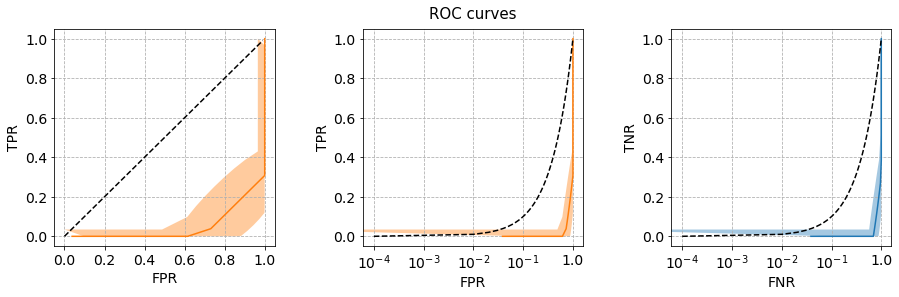

In [228]:
# Check GTC Results
gtc_op_dir = os.path.join(os.getcwd(), "csvs")

for f in os.listdir(gtc_op_dir):
    file_path = os.path.join(gtc_op_dir, f)
    if "test_op.csv" in file_path:
        df = pd.read_csv(file_path, sep="\t")
        #display(df)
        true_lbls = np.array(df['truth'])
        probs = np.zeros((df.shape[0], 2))
        probs[:,0] = df['p0']
        probs[:,1] = df['p1']
        print(true_lbls.shape, probs.shape)
        print(classification_report(np.array(df['truth']), np.array(df['prediction'])))
        au_plots(probs, true_lbls)

In [232]:
print(os.getcwd())

/zfsauton2/home/vsanil/pmx_cpu
